## set up notebook

In [1]:
#!rm genomes/tb927_6/*

In [2]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc

random.seed(1976)
np.random.seed(1976)

# Data Anaylsis

## Experiment SetUp

In [4]:
from IPython.display import Image

In [5]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='gene']
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    for n in gff.iloc[:,-1]:
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
    return desc

desc_dict = make_desc('genomes/tb927_3/tb927_3.gff')
desc_dict['Tb10.v4.0073']

'variant surface glycoprotein (VSG  pseudogene)  putative'

In [6]:
exp = 'P{life_stage}{replica}'
list_df = [exp.format(
    life_stage=life_stage,
    replica=replica) 
 for life_stage in ['1','2','3']
 for replica in ['C','T']
            ]
list_df = [n+'/res/'+n+'/counts.txt' for n in list_df]
print(' '.join(list_df))
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()
#temp_df = pd.read_csv('BSF/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')

P1C/res/P1C/counts.txt P1T/res/P1T/counts.txt P2C/res/P2C/counts.txt P2T/res/P2T/counts.txt P3C/res/P3C/counts.txt P3T/res/P3T/counts.txt


,Chr,Start,End,Strand,Length,/tmp/3126.1.all.q/P1C/P1Csorted.bam,/tmp/3106.1.all.q/P1T/P1Tsorted.bam,/tmp/3107.1.all.q/P2C/P2Csorted.bam,/tmp/3108.1.all.q/P2T/P2Tsorted.bam,/tmp/3109.1.all.q/P3C/P3Csorted.bam,/tmp/3110.1.all.q/P3T/P3Tsorted.bam
Geneid,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,0,0,2,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,5,5,3,6,7,5
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,1,4,0,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,1,0,1,0,0,2
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,0,0,0


In [7]:
#df = pd.read_csv('InData/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')
#df.head()
#data_col = df.columns[6:25]


In [8]:
data_col = df.columns[5:]
data_col

Index(['/tmp/3126.1.all.q/P1C/P1Csorted.bam',
       '/tmp/3106.1.all.q/P1T/P1Tsorted.bam',
       '/tmp/3107.1.all.q/P2C/P2Csorted.bam',
       '/tmp/3108.1.all.q/P2T/P2Tsorted.bam',
       '/tmp/3109.1.all.q/P3C/P3Csorted.bam',
       '/tmp/3110.1.all.q/P3T/P3Tsorted.bam'],
      dtype='object')

In [9]:
indata = df[data_col]
indata.columns = [n.split('/')[3] for  n in indata.columns]
indata = indata[['P1C','P2C','P3C','P1T','P2T','P3T']]
indata.head()

,P1C,P2C,P3C,P1T,P2T,P3T
Geneid,,,,,,
Tb10.v4.0073,1,0,0,0,2,0
Tb10.v4.0074,5,3,7,5,6,5
Tb10.v4.0075,0,4,0,1,0,0
Tb10.v4.0076,1,1,0,0,0,2
Tb10.v4.0077,0,0,0,0,0,0


In [10]:
print(indata.shape)
indata=indata.dropna()
print(indata.shape)
#indata.loc['KS17gene_1749a']
#indata['desc']=[desc_dict.get(n,'none') for n in indata.index.values]
#indata.to_csv('indata.csv')
#indata.head()
#indata.loc['mainVSG-427-2']

(19949, 6)
(19949, 6)


## Missing Data Viz

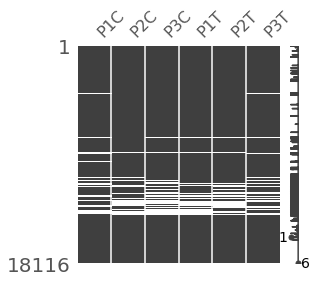

In [11]:
msno.matrix(indata.replace(0,np.nan).dropna(how='all'),figsize=(4, 4))

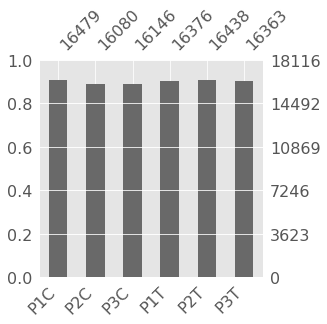

In [12]:
msno.bar(indata.replace(0,np.nan).dropna(how='all'),figsize=(4, 4))

## QC - Corr analysis

In [13]:
!mkdir -p Figures

(5.5, 0.5)


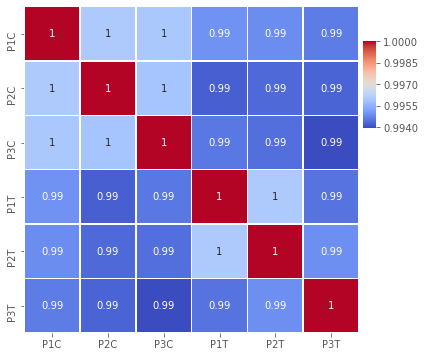

In [14]:
fig,ax=plt.subplots(figsize=(6,6))
cbar_ax = fig.add_axes([.91, .6, .03, .2])
sns.heatmap(np.log2(indata).corr(),
            #vmin=-1,
            cmap='coolwarm',
            annot=True,linewidths=.5,ax=ax, cbar_ax = cbar_ax, cbar=True)
print(ax.get_ylim())
ax.set_ylim(6,0)
plt.savefig('Figures/Figure_2.png')
plt.show()

## QC - MSD

{'r': 'C', 'b': 'T'}


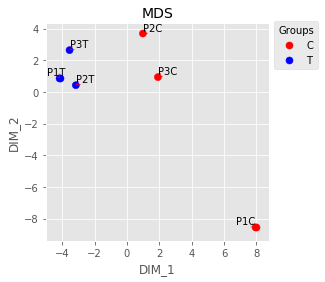

In [15]:
plt.style.use('ggplot')
palette = ['r']*3+['b']*3
fig,ax = plt.subplots(figsize=(4,4), ncols=1, nrows=1)
UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'C','b':'T',
                                                        })
plt.savefig('Figures/Figure_3.png')
plt.show()

## Compute Length and GC content

In [16]:
!mkdir -p InData

In [16]:
!gtf2bed < tb927_6.gtf > tb927_6.bed
!bedtools nuc -fi tb927_6.fa -bed tb927_6.bed >InData/GC_content_927.txt

index file tb927_6.fa.fai not found, generating...


In [17]:
#!bowtie2-build genomes/tb927_5/tb927_5.fa genomes/tb927_5/tb927_5

In [18]:
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [19]:
gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
gc_content = gc_content[gc_content['8_usercol']=='transcript']
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.head()

,length,gccontent
gene_id,,
MSTRG.1,2768,0.505419
MSTRG.2,2482,0.304593
TRY.1,746,0.273458
TRY.2,1531,0.288047
TRY.3,1390,0.379856


In [20]:

indata.head()

#indata.astype(int).to_csv('indata.csv',index=True)



,P1C,P2C,P3C,P1T,P2T,P3T
Geneid,,,,,,
Tb10.v4.0073,1,0,0,0,2,0
Tb10.v4.0074,5,3,7,5,6,5
Tb10.v4.0075,0,4,0,1,0,0
Tb10.v4.0076,1,1,0,0,0,2
Tb10.v4.0077,0,0,0,0,0,0


In [21]:
#metadata=pd.DataFrame()
#metadata['samples']=indata.columns
#metadata['treatment']=['C','C','C','D','D','D','DF','DF','DF','F','F','F']
#metadata['batch']=1
#metadata.reset_index().to_csv('metadata.csv')

In [22]:
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 


(19949, 6)


In [23]:
#indata.loc['mainVSG-427-2']

### edgeR to filter low counts

In [24]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

             P1C P2C P3C P1T P2T P3T
Tb10.v4.0073   1   0   0   0   2   0
Tb10.v4.0074   5   3   7   5   6   5
Tb10.v4.0075   0   4   0   1   0   0
Tb10.v4.0076   1   1   0   0   0   2
Tb10.v4.0077   0   0   0   0   0   0
Tb10.v4.0078 173  96 117 198 165 197


In [25]:
%%R
group <- factor(c(
    'C','C','C',
    'T','T','T'
))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [26]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(14550, 6)

In [27]:
indata=indata.join(gc_content,how='inner')
indata.shape

(14550, 8)

### GC / length content

In [28]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(14550, 6) (14550, 2)


,P1C,P2C,P3C,P1T,P2T,P3T
Tb10.v4.0078,173,96,117,198,165,197
Tb927.8.130,23,11,6,20,17,16
Tb927.8.150,292,177,191,200,251,203
Tb927.8.270,2682,1766,1951,2232,2079,1761
Tb927.8.320,68,25,29,50,42,51


### size factors

In [29]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([95698845, 62105125, 66819012, 64952547, 66553752, 63170283])

In [30]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction

In [31]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

2020-12-16 09:50:37,638 [20244] WARNING  rpy2.rinterface_lib.callbacks:119: [JupyterRequire] R[write to console]: Loading required package: mclust

2020-12-16 09:50:37,806 [20244] WARNING  rpy2.rinterface_lib.callbacks:119: [JupyterRequire] R[write to console]: Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

2020-12-16 09:50:37,814 [20244] WARNING  rpy2.rinterface_lib.callbacks:119: [JupyterRequire] R[write to console]: Loading required package: nor1mix

2020-12-16 09:50:37,844 [20244] WARNING  rpy2.rinterface_lib.callbacks:119: [JupyterRequire] R[write to console]: Loading required package: preprocessCore

2020-12-16 09:50:37,884 [20244] WARNING  rpy2.rinterface_lib.callbacks:119: [JupyterRequire] R[write to console]: Loading required package: splines

2020-12-16 09:50:37,984 [20244] WARNING  rpy2.rinterface_lib.callbacks:119: [JupyterRequire] R[write to console]: Loading required package: quantreg

2020-12-16 09:50:37,994 [20244] W

In [32]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ......
SQN .


In [33]:
#%R cqn.subset

### Viz Bias

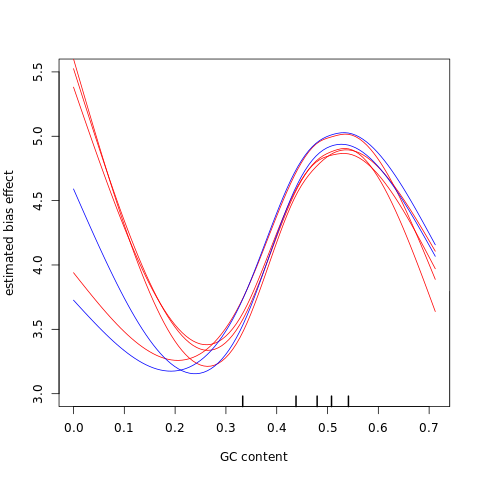

In [34]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'red','red','red','red',
    'blue','blue','blue',
    'green','green','green',
    'yellow','yellow','yellow'
           )
lty =c(1,1,1,
       1,1,1,
      1,1,1,
      1,1,1)

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(3, 5.5), 
        
       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

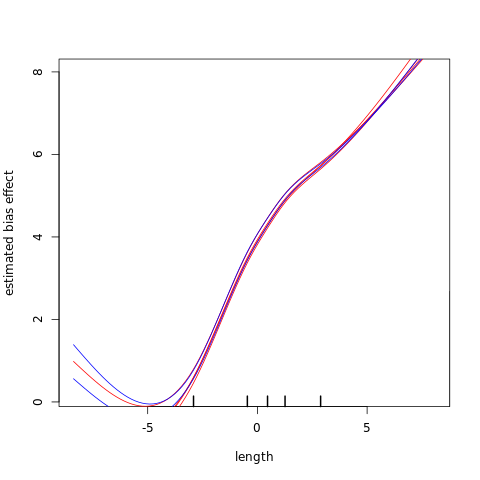

In [35]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'red','red','red','red',
    'blue','blue','blue',
    'green','green','green',
    'yellow','yellow','yellow'
           )
lty =c(1,1,1,
       1,1,1,
      1,1,1,
      1,1,1)

#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(0.2,8), 
    
       )
#dev.off()

### Bias Correction

In [36]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

                   P1C       P2C       P3C       P1T       P2T        P3T
Tb10.v4.0078  3.250189  3.127733  3.199753  3.790160  3.533953  3.9533543
Tb927.8.130  -2.339373 -2.570839 -3.587145 -1.901153 -2.210957 -2.4496537
Tb927.8.150   1.219649  1.129777  1.170416  1.119198  1.543861  1.2470759
Tb927.8.270   4.170497  4.240024  4.235677  4.442793  4.332081  4.1907755
Tb927.8.320  -1.409059 -2.027844 -2.055348 -1.034891 -1.471332 -1.2166076
Tb927.8.350  -1.034891 -1.627244 -1.473074 -1.034891 -1.532921 -0.8907189


In [37]:
#out_table

In [38]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,P1C,P2C,P3C,P1T,P2T,P3T
Tb10.v4.0078,3.250189,3.127733,3.199753,3.790160,3.533953,3.953354
Tb927.8.130,-2.339373,-2.570839,-3.587145,-1.901153,-2.210957,-2.449654
Tb927.8.150,1.219649,1.129777,1.170416,1.119198,1.543861,1.247076
Tb927.8.270,4.170497,4.240024,4.235677,4.442793,4.332081,4.190776
Tb927.8.320,-1.409059,-2.027844,-2.055348,-1.034891,-1.471332,-1.216608


### Visualise Normalized Counts

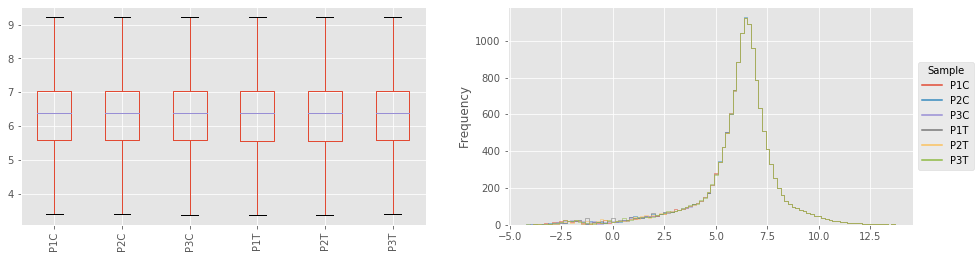

(14550, 6)


In [39]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.show()
print(out_table.shape)

## Differential Expression Analysis

In [40]:
%%R
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )
y <- DGEList(counts=indata, group = group)
y <- calcNormFactors(y)

y <- estimateDisp(y, design_with_all)
# Estimate dispersion
# Fit counts to model
fit_all <- glmQLFit( y, design_with_all )

In [41]:
%%R
contrastCT <- glmQLFTest( fit_all, contrast=makeContrasts( groupT-groupC, levels=design_with_all ) )
tableCT <- topTags(contrastCT, n=Inf, sort.by = "none", adjust.method="BH")$table
head(tableCT)

                  logFC     logCPM          F       PValue         FDR
Tb10.v4.0078 0.68208241  1.1979400 31.4642747 0.0003076558 0.005775989
Tb927.8.130  0.54529014 -1.9972317  2.7536979 0.1307481835 0.297656793
Tb927.8.150  0.12790506  1.6615998  1.7256210 0.2208592344 0.415260436
Tb927.8.270  0.05603467  4.8992681  0.7976839 0.3946026202 0.598037985
Tb927.8.320  0.38197957 -0.5992466  2.7341776 0.1319568375 0.299667861
Tb927.8.350  0.14397632 -0.8913057  0.5185434 0.4893960207 0.679716695


In [42]:
%%R 
t=topTags(contrastCT,n=20)
t$table

                    logFC   logCPM         F       PValue          FDR
Tb927.11.12100  1.8493620 7.554069 1318.2704 3.138994e-11 2.002750e-07
Tb427.BES129.4 -1.7663665 8.272147 1272.7517 3.684438e-11 2.002750e-07
Tb08.27P2.110   1.8447279 5.043706 1201.0892 4.798332e-11 2.002750e-07
Tb927.8.480     1.8664541 5.050719 1165.3766 5.505841e-11 2.002750e-07
KS17gene_4150a  1.9007535 6.767928  911.5365 1.684509e-10 4.901920e-07
Tb927.10.8460   0.9110964 7.288367  813.8274 2.820107e-10 5.425542e-07
Tb11.v5.0308    0.9221461 7.194702  804.8445 2.965918e-10 5.425542e-07
Tb11.v5.0309    0.9257243 7.210121  803.8206 2.983116e-10 5.425542e-07
Tb927.10.8470   0.8947758 7.199632  729.1806 4.642936e-10 7.506079e-07
Tb11.v5.0310    0.8945687 7.062380  698.4324 5.644954e-10 7.552422e-07
Tb427.BES129.2 -2.1027586 7.266928  688.9133 6.007363e-10 7.552422e-07
Tb11.v5.0330    0.9050035 7.628731  683.4347 6.228801e-10 7.552422e-07
Tb927.10.8480   0.8690081 7.423615  664.2419 7.087241e-10 7.847262e-07
Tb427.

In [43]:
desc_dict['Tb08.27P2.90']

'hypothetical protein'

In [44]:
%R -o tableCT

def mod_table(intable):
    intable['mlog10FDR']=-np.log10(intable['FDR'])
    intable['mlog10pvalue']=-np.log10(intable['PValue'])
    intable['desc']=[desc_dict.get(n,n) for n in intable.index.values]
    return intable

tableCT = mod_table(tableCT)


In [45]:
tableCT.sort_values('logFC').tail(10)

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc
Tb927.10.10250,1.224589,4.451152,408.011637,6.401112e-09,5.174232e-06,5.286154,8.193745,EP2 procyclin
MSTRG.272,1.282767,-1.940671,20.704398,1.317804e-03,1.480622e-02,1.829556,2.880149,MSTRG.272
Tb927.8.510,1.369908,0.964316,139.252149,7.467135e-07,1.805784e-04,3.743334,6.126846,hypothetical protein
MSTRG.271,1.526749,-0.861638,57.870300,2.961911e-05,1.460875e-03,2.835387,4.528428,MSTRG.271
Tb08.27P2.70,1.616963,1.638816,308.608014,2.238237e-08,1.144769e-05,4.941282,7.650094,hypothetical protein
TRY.1045,1.840573,1.890935,380.233853,8.787375e-09,6.431446e-06,5.191691,8.056141,TRY.1045
Tb08.27P2.110,1.844728,5.043706,1201.089160,4.798332e-11,2.002750e-07,6.698373,10.318910,PAP2 superfamily putative
Tb927.11.12100,1.849362,7.554069,1318.270355,3.138994e-11,2.002750e-07,6.698373,10.503210,RNA-binding protein putative
Tb927.8.480,1.866454,5.050719,1165.376576,5.505841e-11,2.002750e-07,6.698373,10.259176,phosphatidic acid phosphatase protein putative
KS17gene_4150a,1.900753,6.767928,911.536488,1.684509e-10,4.901920e-07,6.309634,9.773527,KS17gene_4150a


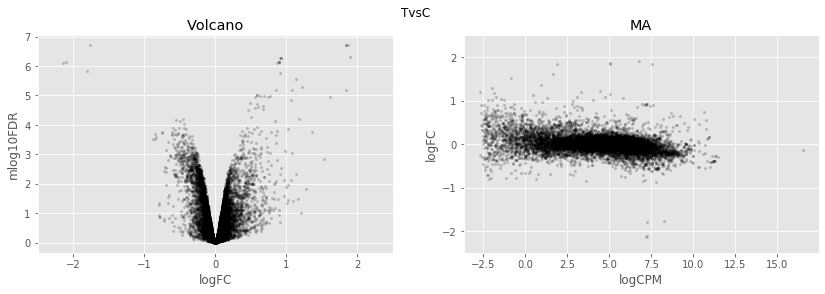

In [46]:
for table,name in zip([tableCT],
                 ['TvsC',]):

    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)
    ax=axes[0]
    table.plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    ax.set_xlim(-2.5,2.5)
    ax.set_title('Volcano')
    ax=axes[1]
    table.plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    ax.set_ylim(-2.5,2.5)
    ax.set_title('MA')
    plt.suptitle(name)
    plt.show()

In [47]:
table.loc['Tb927.11.12100']

logFC                                 1.84936
logCPM                                7.55407
F                                     1318.27
PValue                            3.13899e-11
FDR                               2.00275e-07
mlog10FDR                             6.69837
mlog10pvalue                          10.5032
desc            RNA-binding protein  putative
Name: Tb927.11.12100, dtype: object

In [48]:
def annotated_volcano(table,name,selection=False):
    
    fig,axes=plt.subplots(figsize=(8,8), ncols=1, nrows=1)
    ax=axes
    if not selection:
        selection = table[((table['logFC']>1)|(table['logFC']<-1))
                          &(table['mlog10FDR']>2)&(table['logCPM']>0.8)]
        selection= table.loc[['Tb927.8.510','Tb927.8.490']]
    else:
        selection = table.loc[selection]
    annot_index = selection.index.values
    annot_names = selection['desc'].replace({'phosphatidic acid phosphatase protein  putative':
                                             'PAPP',
                                            'RNA-binding protein  putative':'RBP5',
                                            'PAP2 superfamily  putative':'PAP2',
                                            'THT1 - hexose transporter  putative':'THT1'})
    
    
    UT.make_vulcano(
        table,
        ax,
        x='logFC',
        y='mlog10FDR',
        fc_col = 'logFC',
        pval_col = 'FDR',
        pval_limit=0.01,
        fc_limit=1,
        annot_index=annot_index ,
        annot_names=annot_names,
        expand_text=(1.5, 1.5),
    expand_points=(2, 2),)
    ax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.2), title='Legend')
    ax.set_xlim(-3,3)
    plt.title(name)

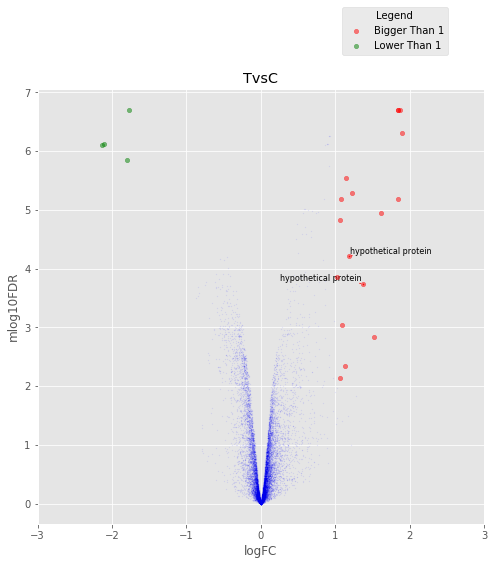

In [49]:
for table,name in zip([tableCT],
                 ['TvsC',]):
    annotated_volcano(table,name)

In [50]:

%%R
#https://rstudio-pubs-static.s3.amazonaws.com/79395_b07ae39ce8124a5c873bd46d6075c137.html
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  lib.size = sizeFactors,
                  group = group, 
                  )

y$offset <- cqn.subset$glm.offset
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmQLFit( y, design_with_all )


#contrastDC <- glmLRT( fit_all, contrast=makeContrasts( groupD-groupC, levels=design_with_all ) )
#tableDC <- topTags(contrastDC, n=Inf, sort.by = "none", adjust.method="BH")$table
#head(tableDC)


contrastCT2 <- glmQLFTest( fit_all, contrast=makeContrasts( groupT-groupC, levels=design_with_all ) )
tableCT2 <- topTags(contrastCT2, n=Inf, sort.by = "none", adjust.method="BH")$table
head(tableCT2)

                 logFC     logCPM          F      PValue        FDR
Tb10.v4.0078 0.5699144  1.1985863 22.7753802 0.001184903 0.01445124
Tb927.8.130  0.5601431 -1.9978962  2.1081973 0.182382976 0.36642810
Tb927.8.150  0.1357135  1.6617230  1.4547805 0.260243280 0.45705917
Tb927.8.270  0.1114432  4.9005428  3.2749204 0.105726851 0.25861033
Tb927.8.320  0.5329902 -0.5995010  5.0762556 0.052403267 0.16653483
Tb927.8.350  0.2029288 -0.8920634  0.6342062 0.447475416 0.64196089


In [51]:
%R -o tableCT2
tableCT2 = mod_table(tableCT2)

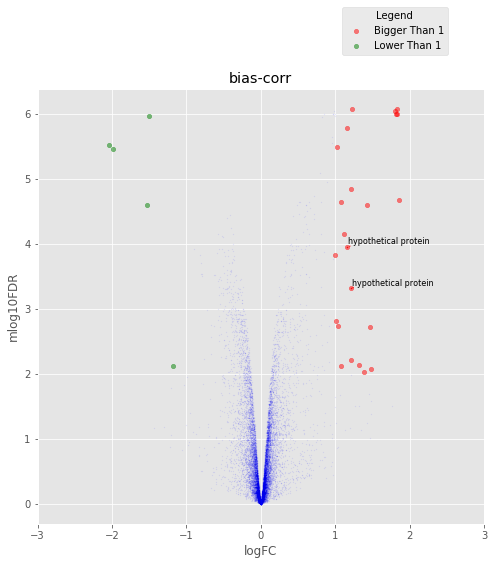

In [52]:
annotated_volcano(tableCT2,'bias-corr')

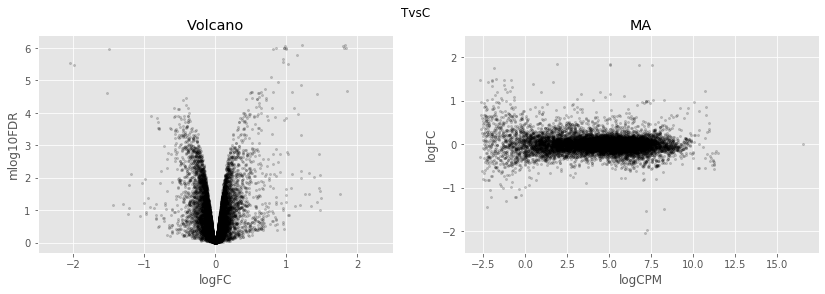

In [53]:
for table,name in zip([tableCT2],
                 ['TvsC',]):

    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)
    ax=axes[0]
    table.plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    ax.set_xlim(-2.5,2.5)
    ax.set_title('Volcano')
    ax=axes[1]
    table.plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    ax.set_ylim(-2.5,2.5)
    ax.set_title('MA')
    plt.suptitle(name)
    plt.show()

In [54]:
tableCT2[tableCT2['mlog10FDR']>4].sort_values('logFC').tail(20)

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc
Tb927.10.8450,0.888752,6.693319,417.538275,1.584508e-08,1.097838e-05,4.959462,7.800105,glucose transporter 1E
Tb11.v5.0310,0.951372,7.072681,661.163182,2.309019e-09,2.239748e-06,5.649801,8.636573,THT1 - hexose transporter putative
Tb927.10.8480,0.954440,7.433859,620.252963,3.019850e-09,2.746176e-06,5.561272,8.520015,glucose transporter putative
Tb927.10.8470,0.969314,7.209957,882.731909,6.839388e-10,9.951310e-07,6.002120,9.164983,glucose transporter putative
Tb927.10.8440,0.974678,6.989841,888.074260,6.667612e-10,9.951310e-07,6.002120,9.176030,glucose transporter 1B
Tb927.10.8460,0.990468,7.298830,1124.991453,2.458124e-10,8.941427e-07,6.048593,9.609396,glucose transporter putative
Tb11.v5.0308,0.992163,7.205389,831.201779,8.812687e-10,1.068538e-06,5.971210,9.054892,THT1 - hexose transporter putative
Tb11.v5.0309,0.996560,7.220800,961.024303,4.779522e-10,9.900820e-07,6.004329,9.320615,THT1 - hexose transporter putative
Tb11.v5.0330,1.022546,7.639434,582.948242,3.918237e-09,3.167241e-06,5.499319,8.406909,THT1 - hexose transporter putative
Tb927.6.520,1.077451,4.776289,332.503731,4.091965e-08,2.288912e-05,4.640371,7.388068,EP3-2 procyclin


In [55]:
tableCT2[tableCT2['mlog10FDR']>4].sort_values('logFC').head(5)

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc
Tb427.BES129.3,-2.037983,7.163869,601.687452,3.430908e-09,0.000003,5.532177,8.464591,Tb427.BES129.3
Tb427.BES129.2,-1.981653,7.247237,566.553300,4.416495e-09,0.000003,5.470813,8.354922,Tb427.BES129.2
Tb427VSG-6609,-1.528073,7.222348,307.850550,5.634603e-08,0.000025,4.604788,7.249137,Tb427VSG-6609
Tb427.BES129.4,-1.500600,8.254240,834.976177,8.646055e-10,0.000001,5.971210,9.063182,Tb427.BES129.4
TRY.133,-0.578144,6.100852,212.639426,2.595278e-07,0.000071,4.147229,6.585816,TRY.133


In [57]:
tableCT2.to_csv('tableCT.csv.zip')

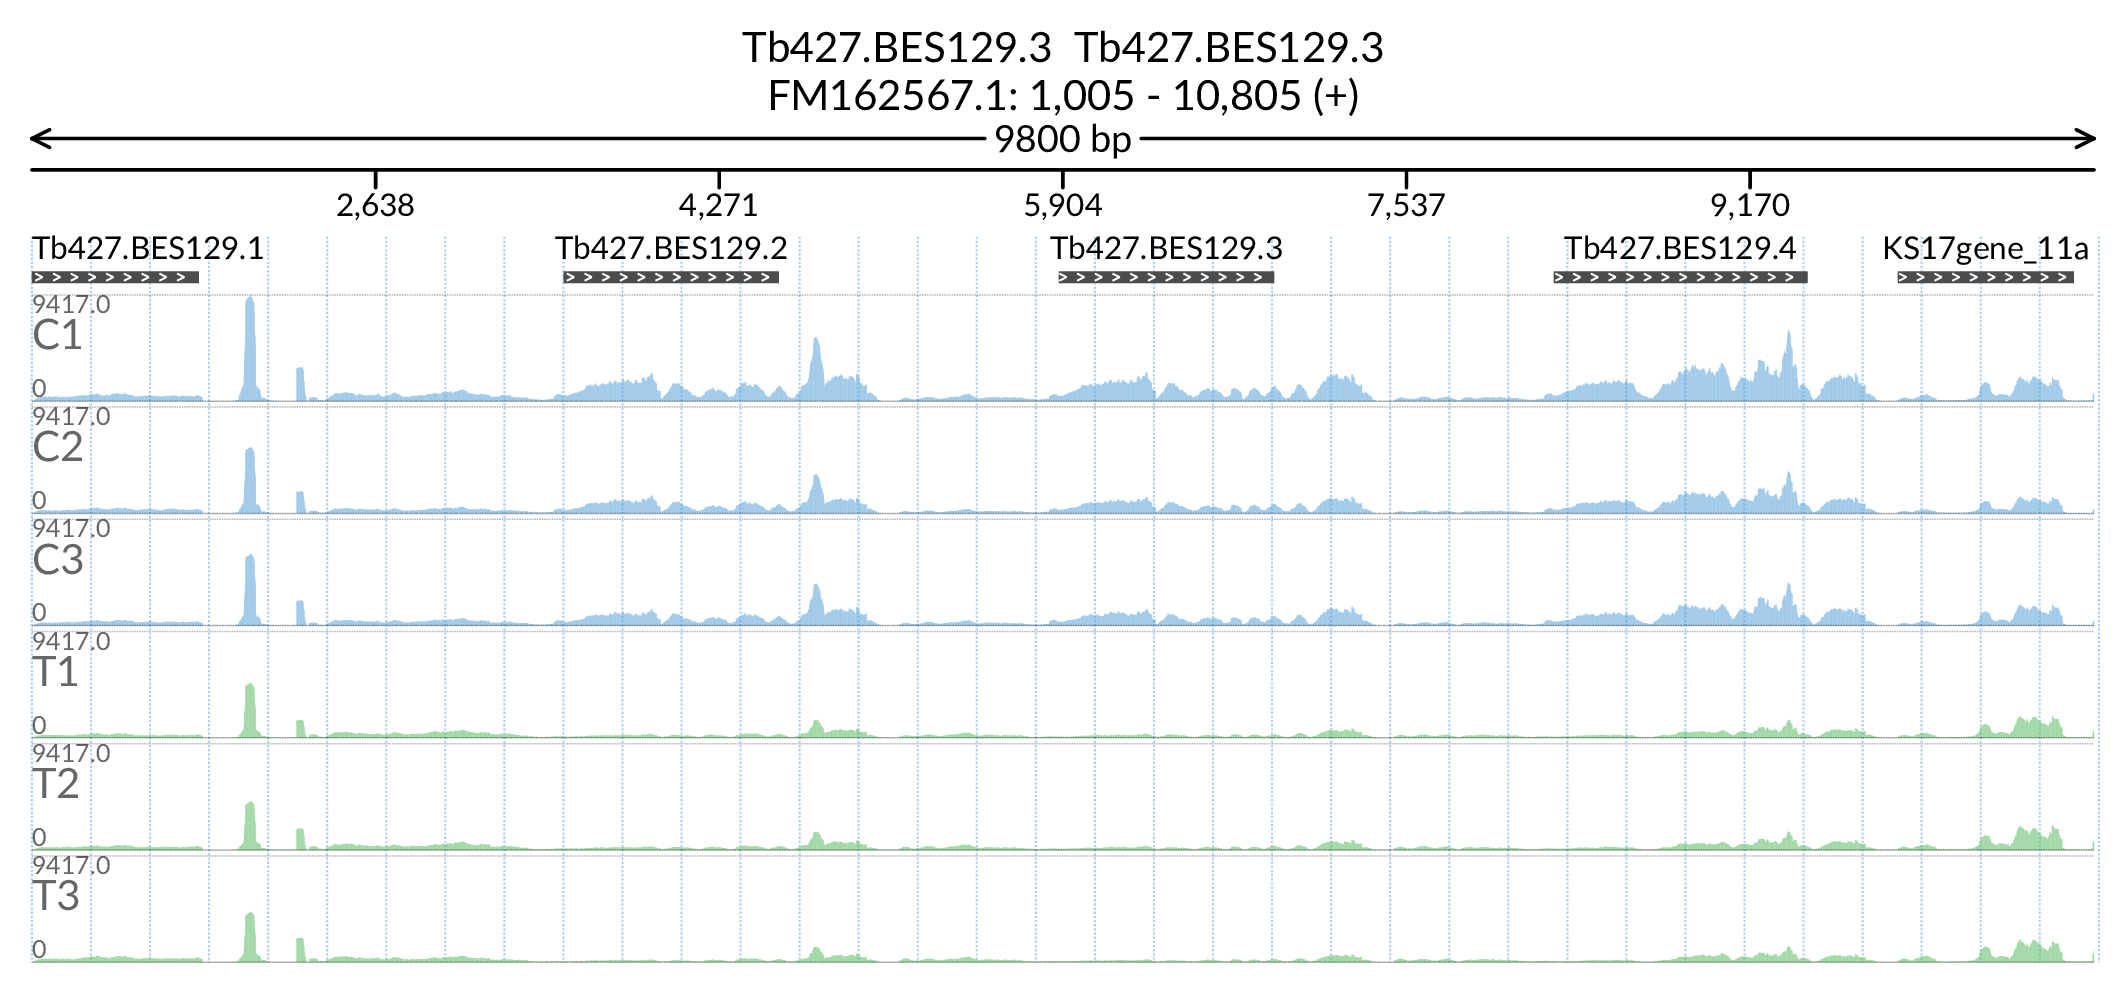

In [56]:
Image('Figures/Tb427.BES129.3_paperFig.png')

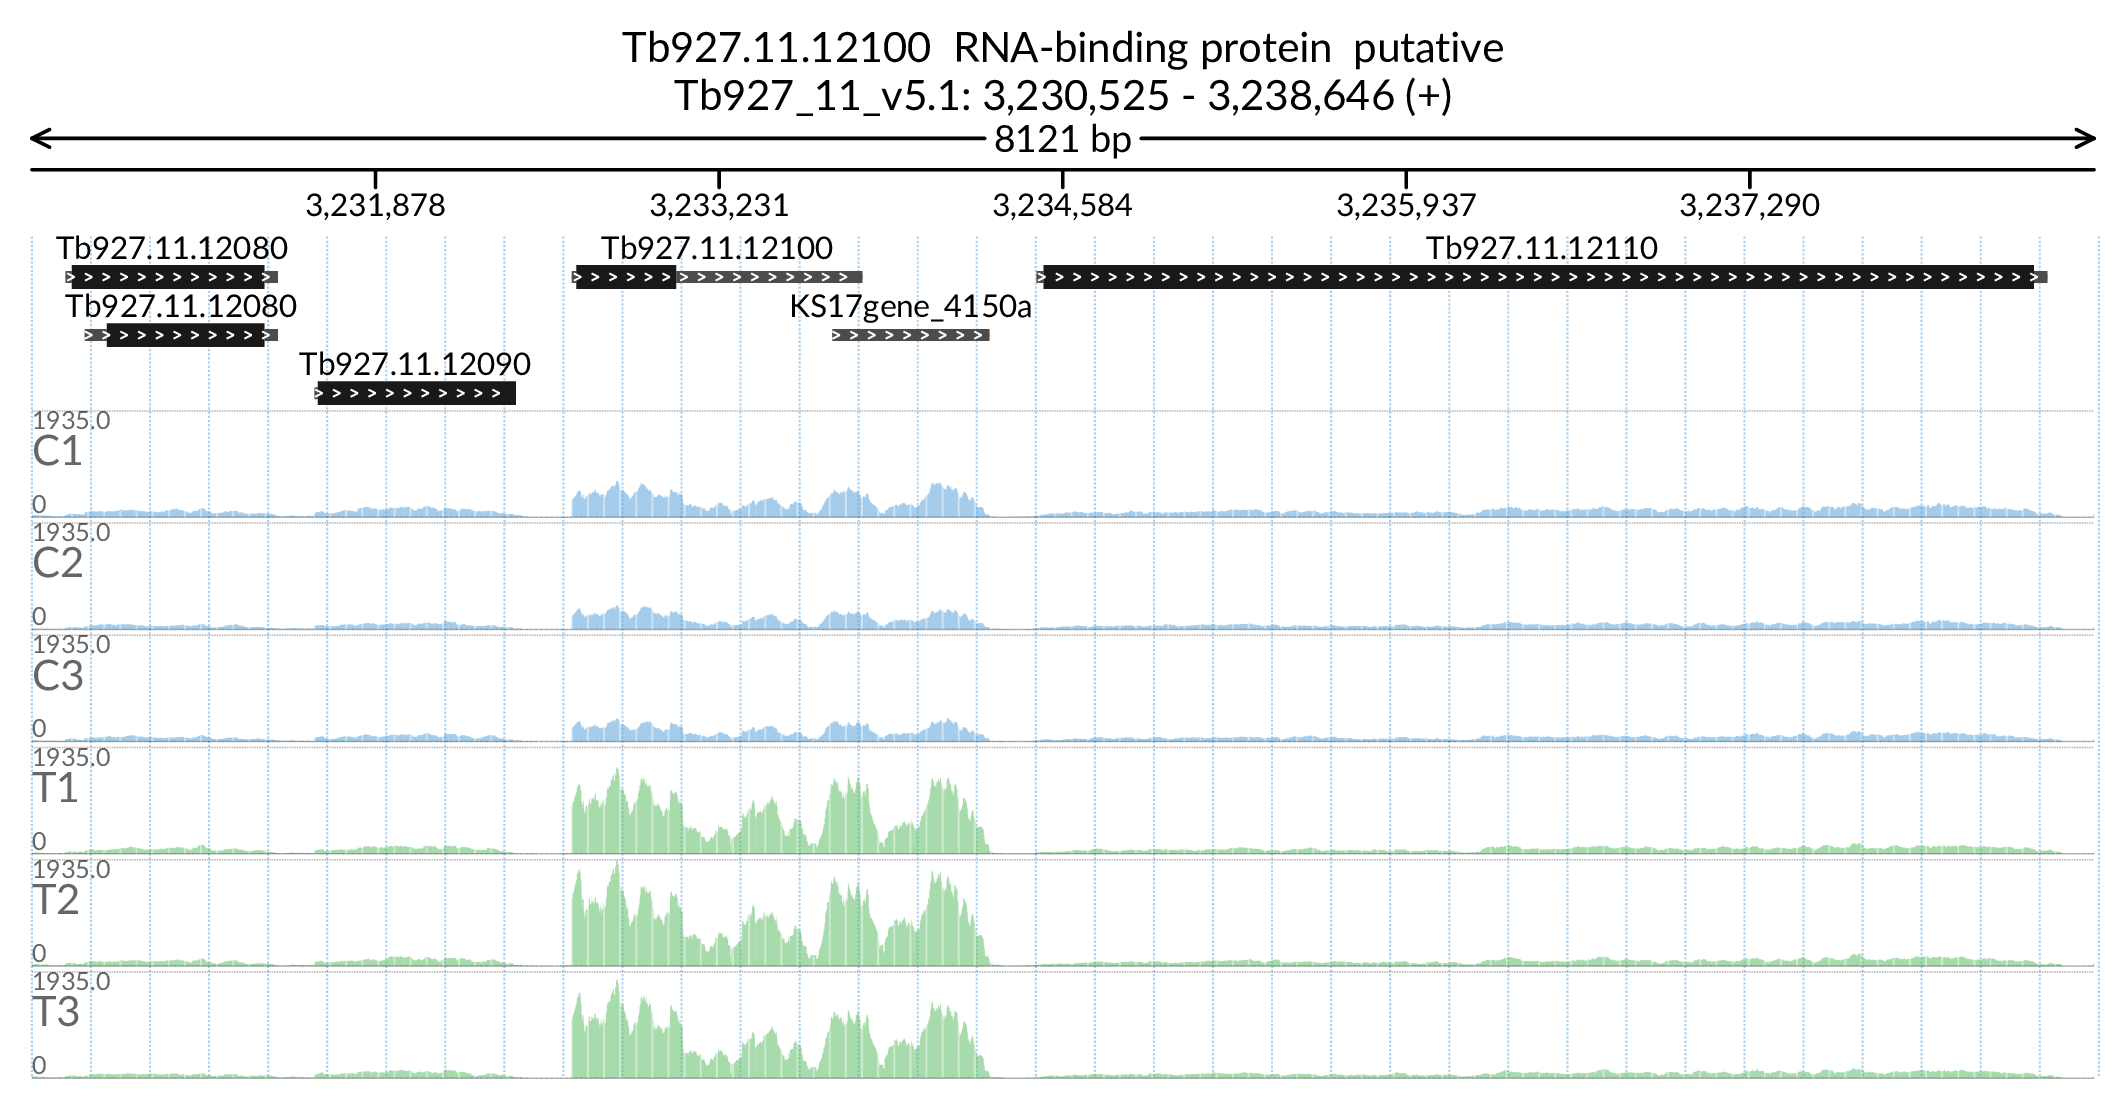

In [57]:
Image('Figures/Tb927.11.12100_paperFig.png')

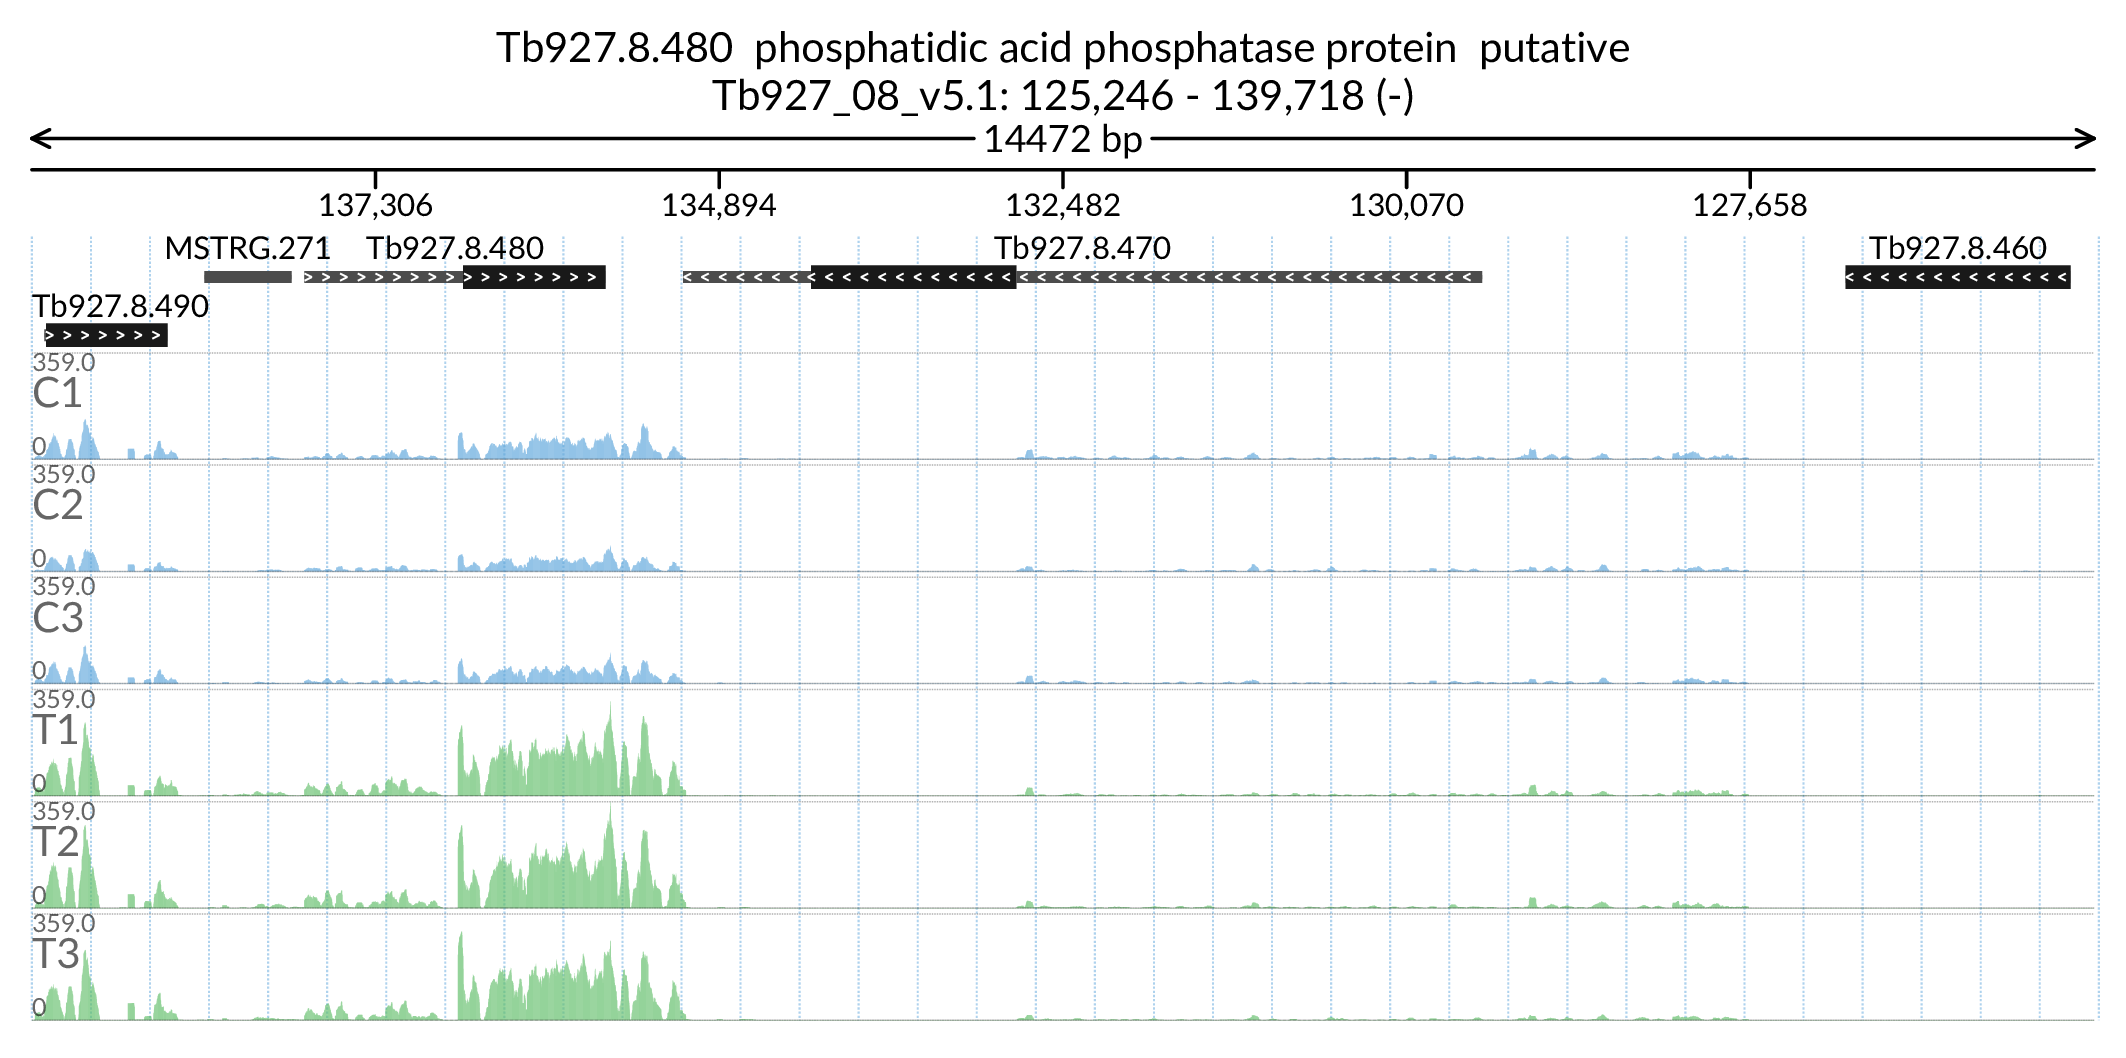

In [58]:
Image('Figures/Tb927.8.480_paperFig.png')

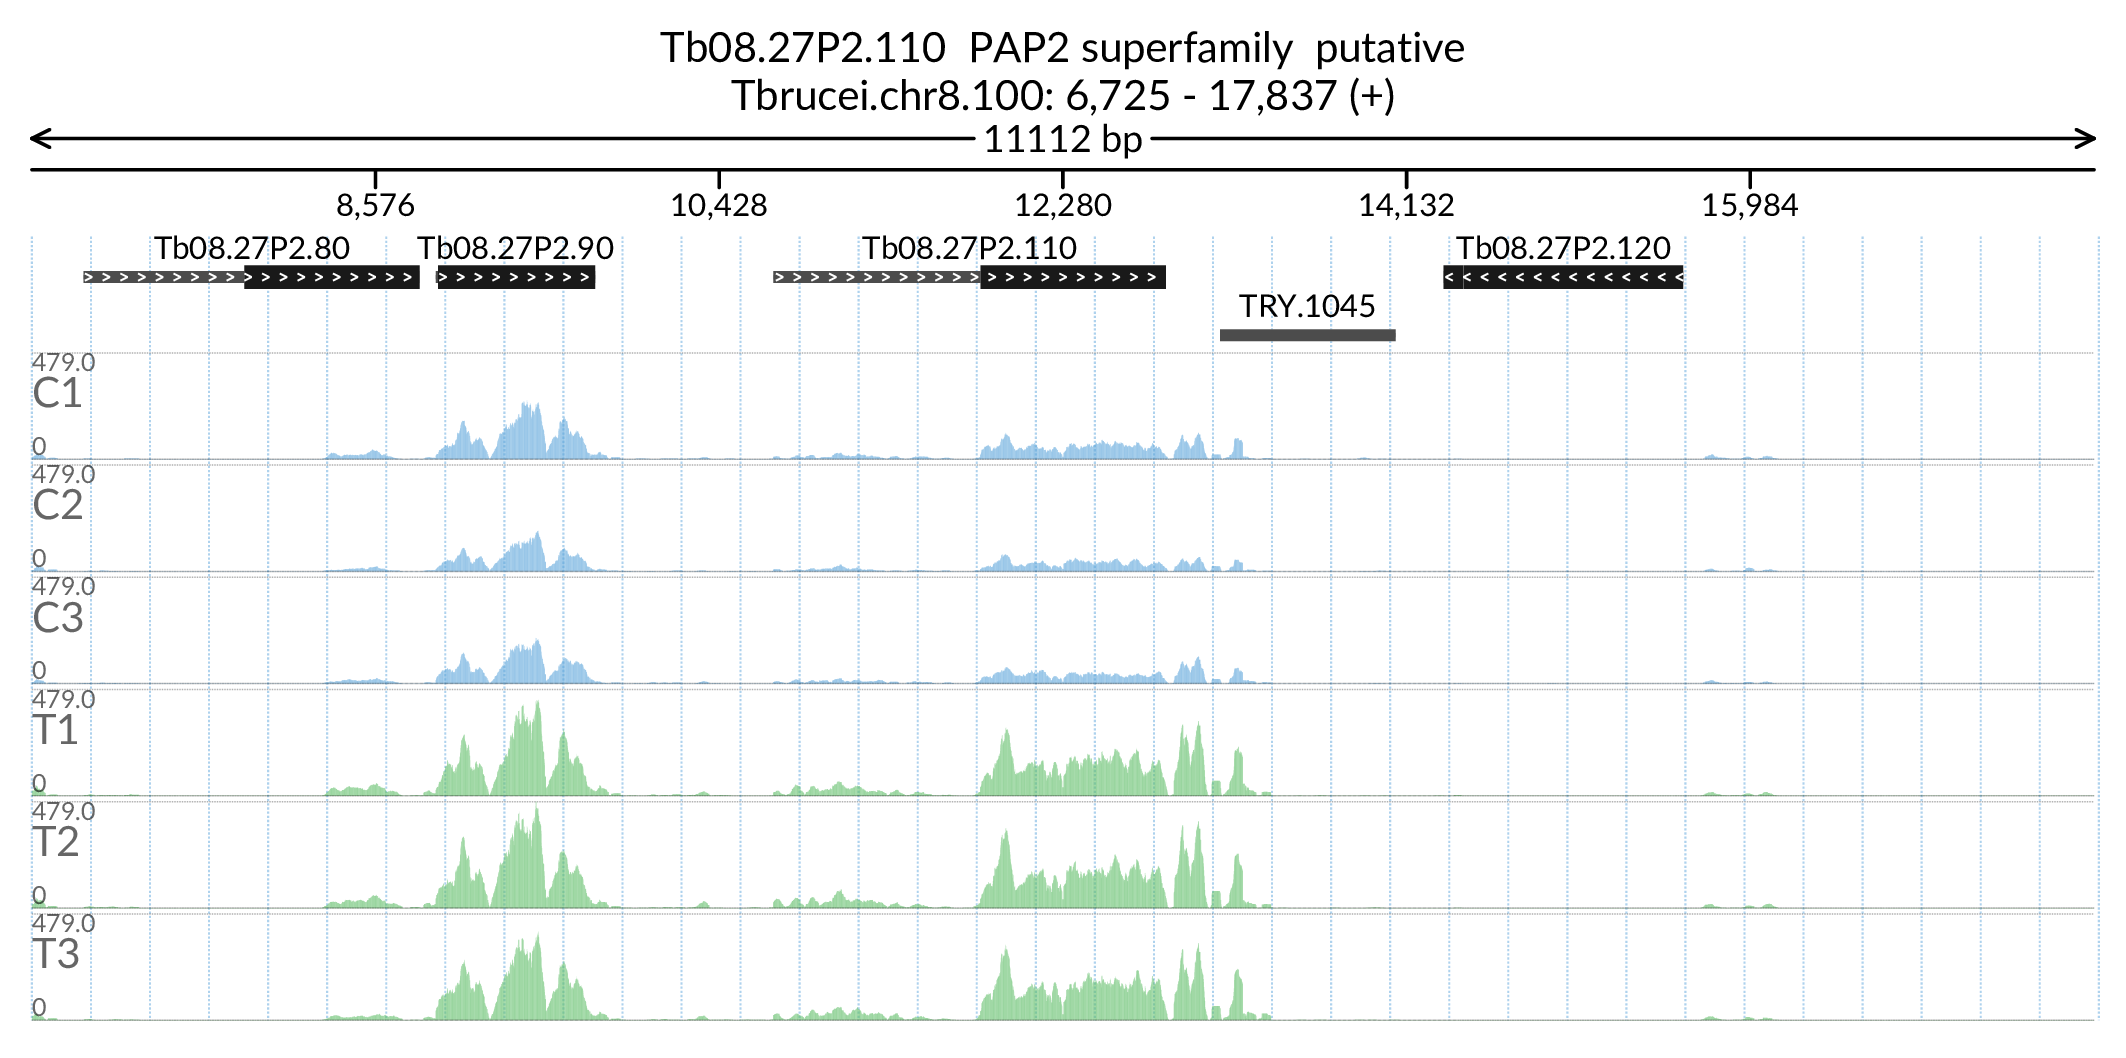

In [59]:
Image('Figures/Tb08.27P2.110_paperFig.png')

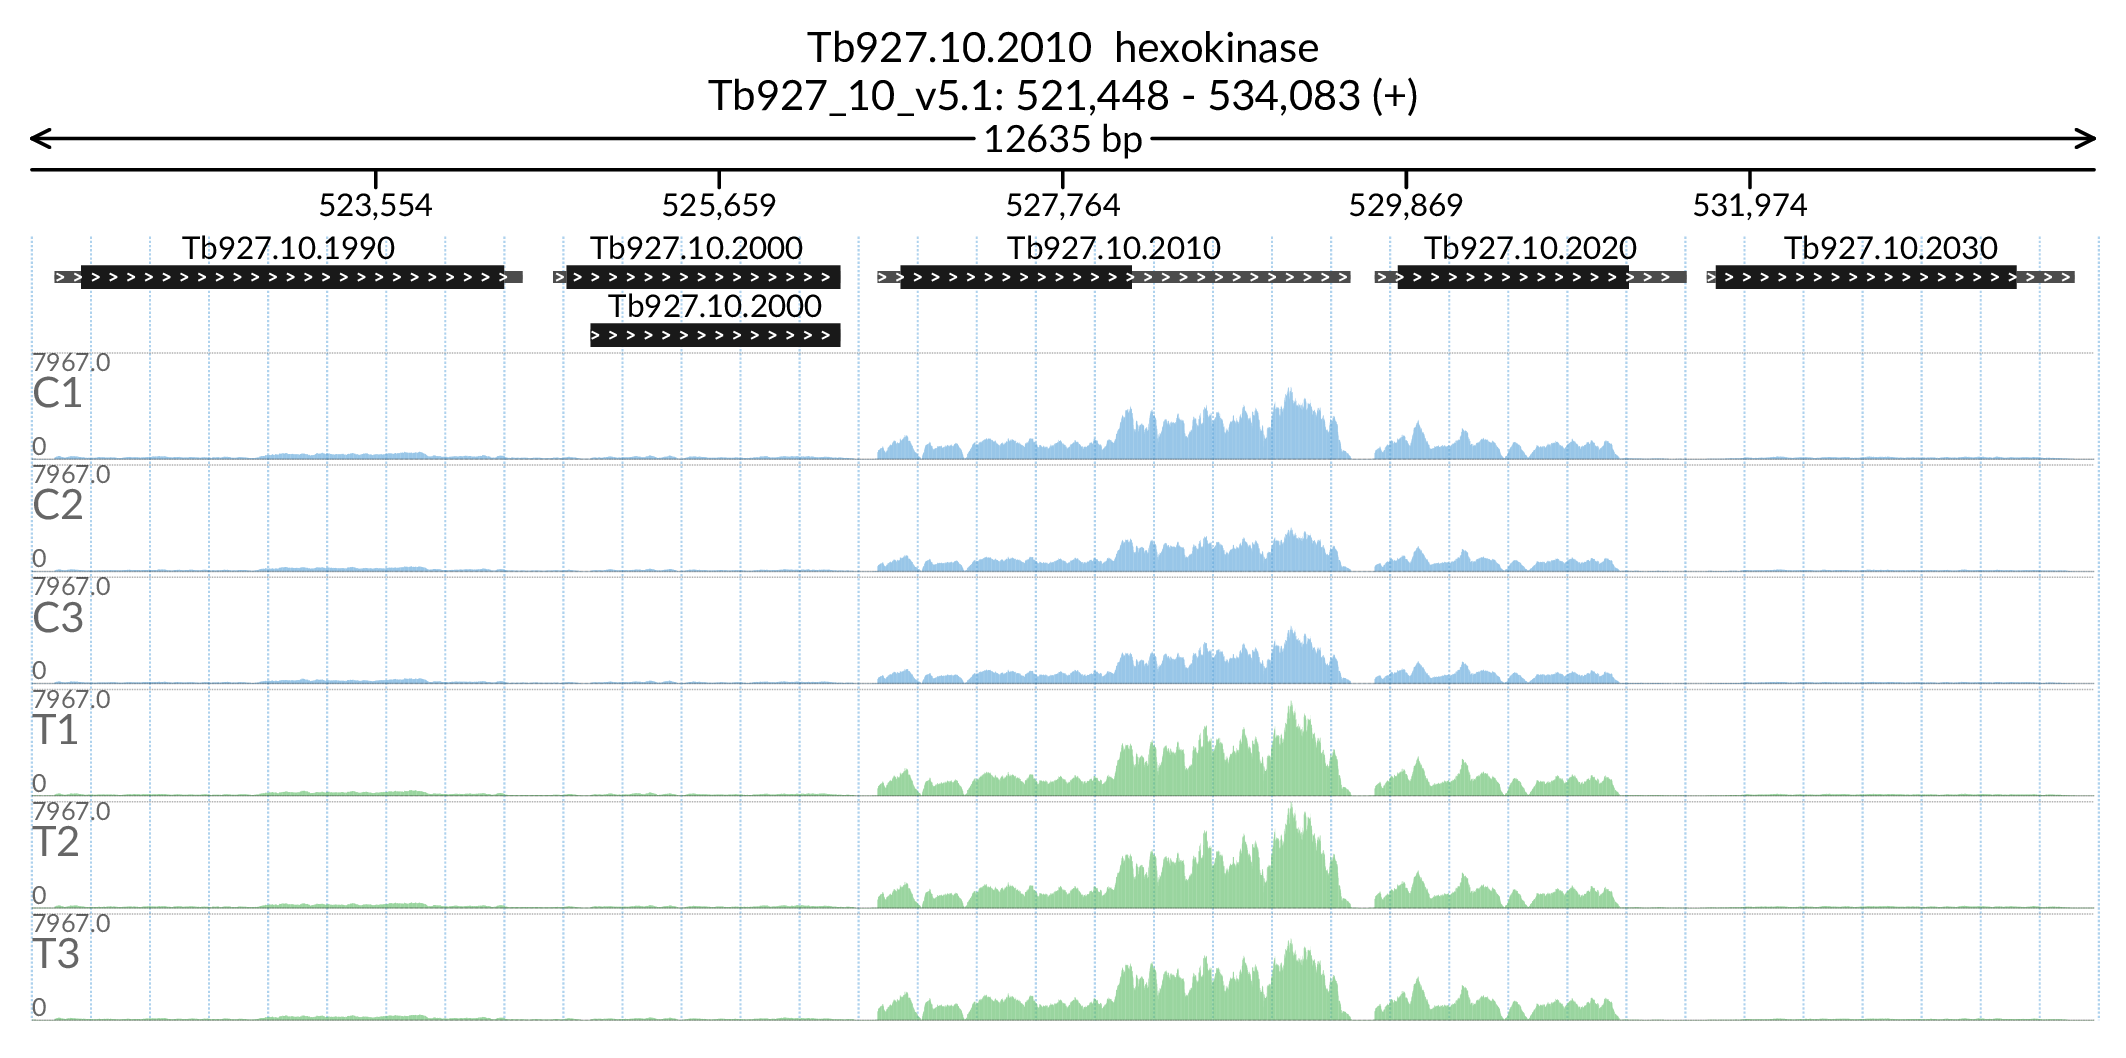

In [60]:
Image('Figures/Tb927.10.2010_paperFig.png')

In [61]:
!jupyter nbconvert --to html_toc FiguresPaper.ipynb

[NbConvertApp] Converting notebook FiguresPaper.ipynb to html_toc
[NbConvertApp] Support files will be in FiguresPaper_files/
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Making directory FiguresPaper_files
[NbConvertApp] Writing 411595 bytes to FiguresPaper.html
